Help! I don't know what colab is: https://colab.research.google.com/github/data-psl/lectures2020/blob/master/notebooks/01_python_basics.ipynb#scrollTo=qeGAvLq1ALJ4

## Install Dependencies (Packages and Useful Functions)

Run the following cell.
- Python packages
- Download an AI model to help us label pictures
- Download a sample image for us to label


In [ ]:
## Install Packages

!pip install matplotlib
import matplotlib
matplotlib.use('Agg')
!pip install ipympl
from google.colab import output
output.enable_custom_widget_manager()
%matplotlib ipympl


!pip install git+https://github.com/facebookresearch/segment-anything.git
!pip install opencv-python pycocotools

## Download the Segment Anything Model

!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

## Download an image

!wget https://raw.githubusercontent.com/eric-yim/streaming-people-counter/main/people_sample.png
!wget https://raw.githubusercontent.com/eric-yim/streaming-people-counter/main/road.png
## Create useful functions
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=100):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
def show_point(coords, label, ax, marker_size=100):
    if label==0:
      color='red'
    else:
      color='green'
    ax.scatter([coords[0]], [coords[1]], color=color, marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
     
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))   

def show_boxes(boxes, ax):
    for box in boxes:
      show_box(box,ax)

## Load an Image

To train an object detector, we need a labeled dataset. The dataset includes images and bounding box labels.

In the following sections we will:
- Label boxes manually
- Label boxes with the help of AI tools

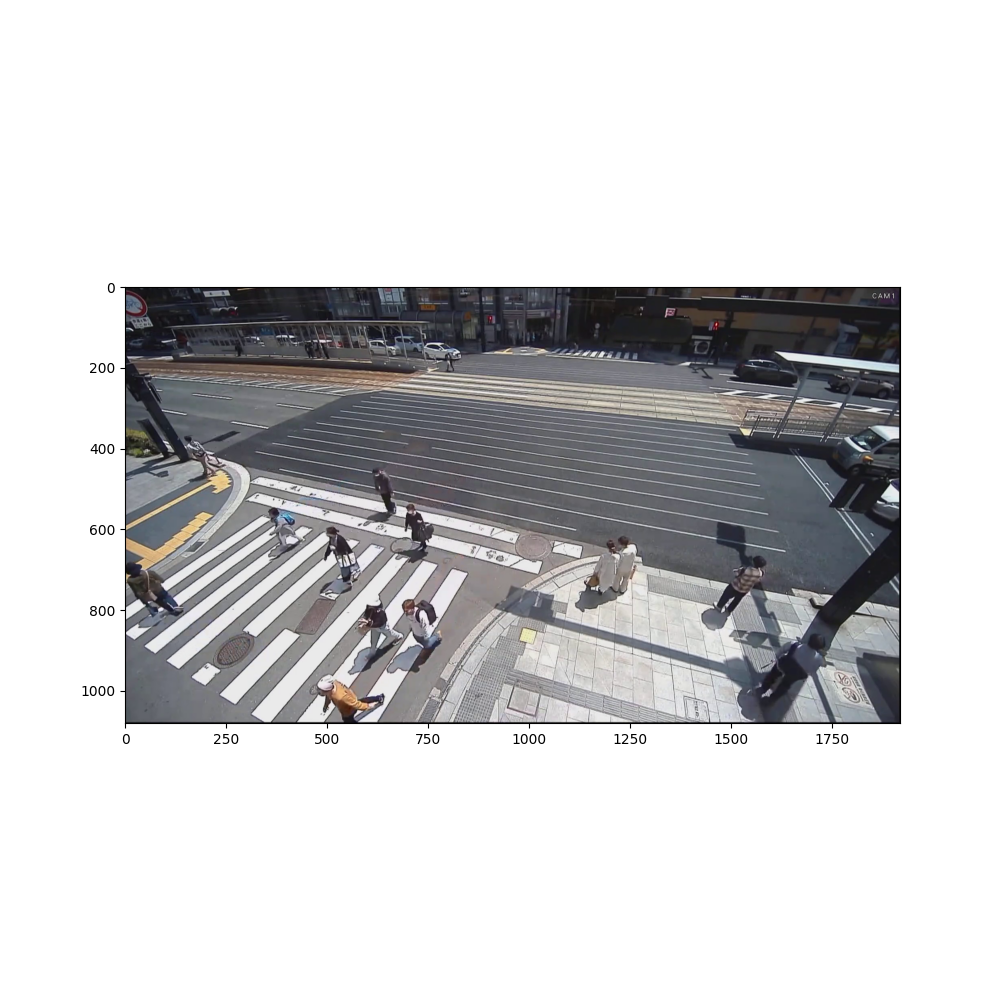

In [4]:
# Load and display image

image = cv2.imread('people_sample.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('on')
plt.show()

## Fully Manual Labeling

On the image below, create a series of boxes.
- Your first click defines the top, left corner
- Your second click defines the bottom, right corner

You should box every person on screen.

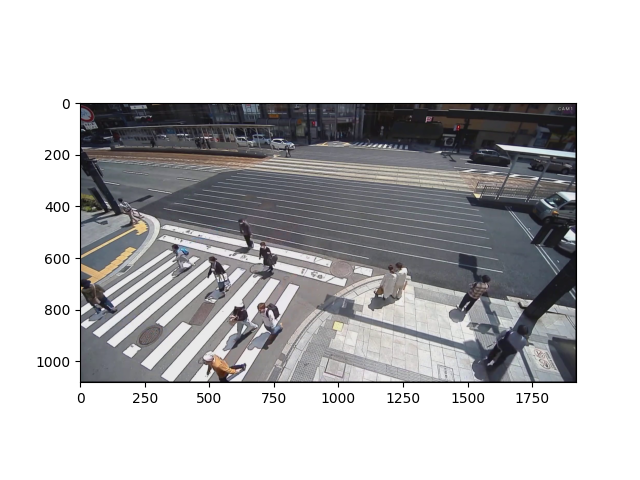

In [17]:
BOUNDING_BOXES = []
CLICKED_POINTS = []
plt.clf()
fig, AX = plt.subplots()

AX.imshow(image)
def onclick(event):
    global CLICKED_POINTS, AX, image
    ix, iy = event.xdata, event.ydata
    if ix and iy:
      CLICKED_POINTS.append([ix,iy])
    # When we have 2 points, that defines a box. We add that to our list of boxes
    if len(CLICKED_POINTS)==2:
      top_left = [min(CLICKED_POINTS[0][0],CLICKED_POINTS[1][0]),
                  min(CLICKED_POINTS[0][1],CLICKED_POINTS[1][1])]
      bottom_right = [max(CLICKED_POINTS[0][0],CLICKED_POINTS[1][0]),
                  max(CLICKED_POINTS[0][1],CLICKED_POINTS[1][1])]
      BOUNDING_BOXES.append(top_left+bottom_right)
      CLICKED_POINTS = []
      AX.cla()
      AX.imshow(image)
      show_boxes(BOUNDING_BOXES,AX)
    elif len(CLICKED_POINTS)==1:
      show_point(CLICKED_POINTS[0],1,AX)

cid = fig.canvas.mpl_connect('button_press_event', onclick)

In [20]:
print("Here are the coordinates for all the boxes you have prepared.")
print("There should be 4 values, which are the top, left and bottom, right of your boxes\n")
for box in BOUNDING_BOXES:
  print(box)

Here are the coordinates for all the boxes you have prepared.
There should be 4 values, which are the top, left and bottom, right of your boxes

[7.241935483870975, 669.5645161290322, 134.98387096774195, 816.6612903225806]
[344.0161290322581, 537.9516129032257, 436.9193548387097, 650.2096774193549]
[483.37096774193554, 580.5322580645161, 595.6290322580646, 743.1129032258065]
[591.758064516129, 437.3064516129032, 680.7903225806451, 557.3064516129032]
[676.9193548387098, 514.7258064516129, 773.6935483870968, 665.6935483870967]
[1141.4354838709678, 603.758064516129, 1238.2096774193549, 770.2096774193549]
[1470.467741935484, 630.8548387096774, 1590.467741935484, 847.6290322580645]
[1559.5, 828.2741935483871, 1741.4354838709676, 1052.7903225806451]
[564.6612903225807, 750.8548387096774, 680.7903225806451, 897.9516129032259]
[661.4354838709678, 758.5967741935484, 793.0483870967741, 928.9193548387096]
[460.1451612903226, 952.1451612903226, 634.3387096774193, 1056.6612903225805]
[146.596774193

## AI Assisted Labeling

Imagine you needed label 5000 images. This could take forever, let's see if other AI models can help us label data. The data then becomes food for the our specialized AI model.

In [24]:
# Load the Segment Anything model
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

# Load image again
image = cv2.imread('people_sample.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

predictor.set_image(image)

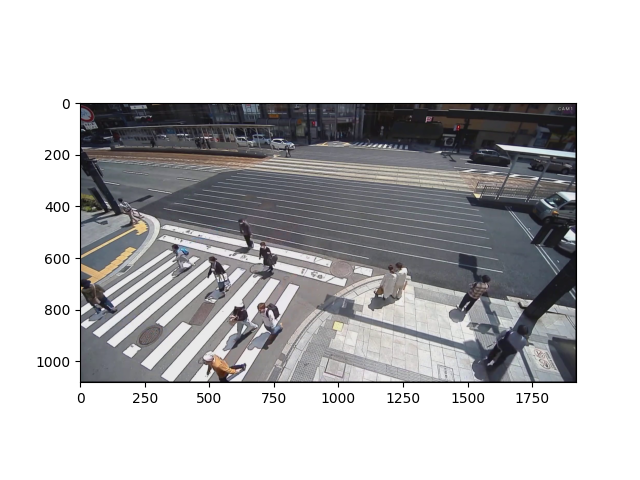

In [58]:
BUFFER=10
CLICKED_POINTS = []
MASKS = []
MASK=None
plt.clf()
fig, AX = plt.subplots()

AX.imshow(image)
def create_index_meshgrid(rows,cols):
    # Create a 2D array using meshgrid
    x, y = np.meshgrid(np.arange(cols),np.arange(rows))

    # Stack the x and y arrays along the third axis to create a 3D array
    result = np.stack((x, y), axis=-1)
    return result
def get_mask(input_point,input_label,out_type='rand'):
    assert out_type in {'rand','best','all'}
    masks, scores, logits = predictor.predict(
      point_coords=input_point,
      point_labels=input_label,
      multimask_output=True
    )
    if out_type=='rand':
      i = np.random.randint(0,len(masks))
      return masks[i]
    elif out_type=='best':
      i = np.argmax(scores,axis=0)
      return masks[i]
    return masks
def get_box_from_mask(mask):
    global BUFFER
    h,w = mask.shape[:2]
    mgrid = create_index_meshgrid(h,w)
    inds = mgrid[mask]
    minx = max(np.min(inds[:,0])-BUFFER,0)
    miny = max(np.min(inds[:,1])-BUFFER,0)
    maxx = min(np.max(inds[:,0])+BUFFER,w)
    maxy = min(np.max(inds[:,1])+BUFFER,h)
    return [minx,miny,maxx,maxy]
def onclick(event):
    global CLICKED_POINTS, AX, image,MASK,MASKS
    ix, iy = event.xdata, event.ydata
    AX.cla()
    AX.imshow(image)
    if ix and iy:
      if event.button==1:
        CLICKED_POINTS.append([ix,iy])
        MASK= get_mask(np.array([[ix,iy]]),np.arange(1)+1,'rand')
        show_mask(MASK,AX)
        show_point([ix,iy],1,AX)
      elif event.button==3:
        if MASK is not None:
      
          MASKS.append(MASK)
    boxes = [get_box_from_mask(mask) for mask in MASKS]
    show_boxes(boxes,AX)


    
cid = fig.canvas.mpl_connect('button_press_event', onclick)

In [60]:
print(f"You have {len(MASKS)} masks, with shape: {MASKS[0].shape}.")
print("Here are the boxes associated with each mask.\n")
boxes = [get_box_from_mask(mask) for mask in MASKS]
for box in boxes:
  print(box)

You have 7 masks, with shape: (1080, 1920).
Here are the boxes associated with each mask.

[0, 672, 153, 826]
[357, 544, 431, 646]
[483, 583, 588, 750]
[579, 775, 659, 854]
[676, 765, 769, 873]
[676, 765, 769, 873]
[467, 952, 652, 1080]


## Synthetic Data Augmentation

There's one more trick we can do if we have segmented portions of our image.
We can augment our dataset by placing objects in new environments. This is essential if we have many images with a constant background.

In [62]:
print(f"You have {len(MASKS)} masks, with shape: {MASKS[0].shape}.")

You have 7 masks, with shape: (1080, 1920).


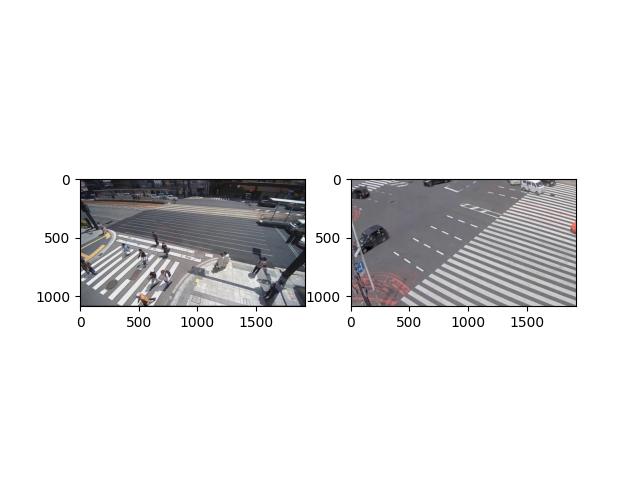

In [64]:
# Load image again
source_image = cv2.cvtColor(cv2.imread('people_sample.png'), cv2.COLOR_BGR2RGB)
# Load new background
target_image = cv2.cvtColor(cv2.imread('road.png'), cv2.COLOR_BGR2RGB)

plt.clf()
fig, axes = plt.subplots(1,2)
axes[0].imshow(source_image)
axes[1].imshow(target_image)

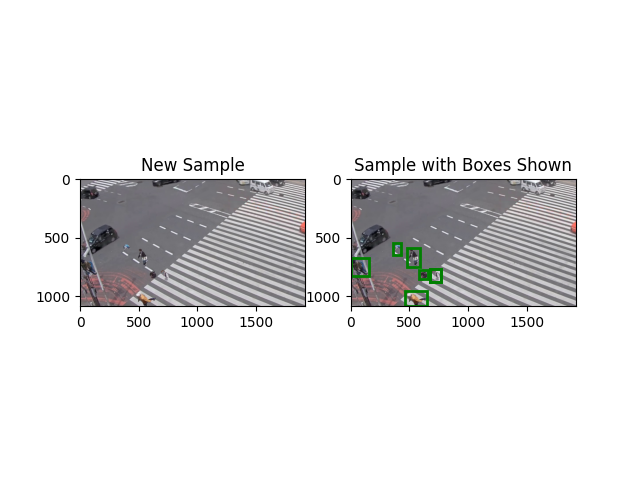

In [78]:
def create_synthetic_sample(source,target,masks):
    h,w = source.shape[:2]
    new = target.copy()
    new = cv2.resize(new,(w,h))
    for mask in masks:
      new[mask]=source[mask]
    return new
sample = create_synthetic_sample(source_image,target_image,MASKS)
cv2.imwrite('synthetic_sample.png',cv2.cvtColor(sample, cv2.COLOR_BGR2RGB))
plt.clf()
fig, axes = plt.subplots(1,2)
axes[0].imshow(sample)
axes[0].set_title("New Sample")
axes[1].imshow(sample)
axes[1].set_title("Sample with Boxes Shown")
boxes = [get_box_from_mask(mask) for mask in MASKS]
show_boxes(boxes,axes[1])


## Create Our Annotations in COCO Format
A lot of training algorithms work with the COCO format. The format is simply a JSON file that looks like below.

```
main file
{
  "images": LIST_OF_IMAGES,
  "annotations": LIST_OF_ANNOTATIONS,
  "categories": LIST_OF_CATEGORIES
}

An image
{
  "file_name": "sample.png",
  "height": 1080,
  "width": 1920,
  "id": 0    # A unique number
}

A Category
{
  "supercategory": "person",
  "id": 0,   # A unique number
  "name": "person"    # Name of Category
}

An annotation
{
  "segmentation": [],
  "area": 200,    # pixel area of detection
  "iscrowd": 0,
  "image_id": 0,   # Matches an image's id
  "bbox": [100,100,10,10],   #top left, w h
  "category_id": 0 ,    # Matches a category's id
  "id": 0    # A unique number
}


```

In [72]:
images = [
  {
    "file_name": "people_sample.png",
    "height": 1080,
    "width": 1920,
    "id": 0    
  },
  {
    "file_name": "synthetic_sample.png",
    "height": 1080,
    "width": 1920,
    "id": 1
  }
]
categories = [
  {
    "supercategory": "person",
    "id": 0,   
    "name": "person"
  }
]

In [75]:
import json
annotations = []
for img in images:
  boxes = [get_box_from_mask(mask) for mask in MASKS]
  for box in boxes:
    x0,y0,x1,y1 = map(float,box)
    w = x1-x0
    h = y1-y0
    annotation = {
        "segmentation": [],
        "area": w*h,    # pixel area of detection
        "iscrowd": 0,
        "image_id": img["id"],   # Matches an image's id
        "bbox": [x0,y0,w,h],   #top left, w h
        "category_id": categories[0]["id"] ,    # Matches a category's id
        "id": len(annotations)    # A unique number
      }
    annotations.append(annotation)
print(f"You have {len(annotations)} annotations. The first looks like this:\n\n")
print(json.dumps(annotations[0],indent=2))

You have 14 annotations. The first looks like this:


{
  "segmentation": [],
  "area": 23562.0,
  "iscrowd": 0,
  "image_id": 0,
  "bbox": [
    0.0,
    672.0,
    153.0,
    154.0
  ],
  "category_id": 0,
  "id": 0
}


In [76]:
save_location = "annotations.json"
print(f"Saving to disk at {save_location}")
full_dump = {
    "images": images,
    "annotations": annotations,
    "categories": categories
}
json.dump(full_dump,open(save_location,'w'),indent=2)

Saving to disk at annotations.json


In [77]:
print(f"Congratulations! You now have a dataset with {len(images)} images and {len(annotations)} in the COCO format!\nThis dataset can be used to train an Object Detector!")

Congratulations! You now have a dataset with 2 images and 14 in the COCO format!
This dataset can be used to train an Object Detector!
